<a href="https://colab.research.google.com/github/emiletimothy/Caltech-CS155-2023/blob/main/set4/prob2_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Part A: Data Setup

In [17]:
# data preprocessing

df = pd.read_csv("data/COVID-19_Case_Surveillance_Public_Use_Data_Subset.csv")

# TODO: preprocess df
df = df.dropna()
cols = ['cdc_report_dt', 'race_ethnicity_combined']
df = df.drop(cols, axis=1)
df = df[df.death_yn != 'Missing']
df = df[df.death_yn != 'Unknown']

df = df.replace({'Male' : float(-1), 'Female' : float(1), 
            'Laboratory-confirmed case' : float(-1), 'Probable Case' : float(1),
            'Unknown' : float(0), 'Missing' : float(0),
            'No': -1, 'Yes': 1,
            '0 - 9 Years' : float(5),
            '10 - 19 Years' : float(15),
            '20 - 29 Years' : float(25),
            '30 - 39 Years' : float(35),
            '40 - 49 Years' : float(45),
            '50 - 59 Years' : float(55),
            '60 - 69 Years' : float(65),
            '70 - 79 Years' : float(75),
            '80+ Years' : float(85)})

df['cdc_case_earliest_dt '] = df['cdc_case_earliest_dt '].apply(pd.to_datetime).apply(lambda x: x.value / 10**12)
df['pos_spec_dt'] = df['pos_spec_dt'].apply(pd.to_datetime).apply(lambda x: x.value / 10**12)
df['onset_dt'] = df['onset_dt'].apply(pd.to_datetime).apply(lambda x: x.value / 10**12)

sc_train = StandardScaler()

Y = df['death_yn'].replace({-1 : float(0)})
X = df.drop('death_yn', axis=1)

for col in X.columns:
    X[[col]] = sc_train.fit_transform(X[[col]])

X = X.values
Y = Y.values

In [18]:
# TODO: make sure your data can be converted to torch tensors

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=0)

train_X = torch.FloatTensor(train_X)
test_X = torch.FloatTensor(test_X)
train_y = torch.LongTensor(train_y)
test_y = torch.LongTensor(test_y)
# make datasets and dataloaders

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True) 


# Part B: Linear Neural Network

## Model Setup

In [19]:
# TODO: Make your model, optmizer, and loss function here.

model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Linear(train_X.shape[1], 5),
    nn.Softmax(dim=1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()


## Training Loop

In [30]:
# Some layers, such as Dropout, behave differently during training

def train(model, optimizer, loss_fn):
    model.train()

    for epoch in range(10):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Erase accumulated gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Calculate loss
            loss = loss_fn(output, target)

            # Backward pass
            loss.backward()
            
            # Weight update
            optimizer.step()

        # Track loss each epoch
        print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))
        print("Average Loss: %f" % (loss.item() / len(train_loader.dataset)))
train(model, optimizer, loss_fn)

Train Epoch: 1  Loss: 0.9049
Average Loss: 0.000019
Train Epoch: 2  Loss: 0.9049
Average Loss: 0.000019
Train Epoch: 3  Loss: 1.0299
Average Loss: 0.000022
Train Epoch: 4  Loss: 1.0299
Average Loss: 0.000022
Train Epoch: 5  Loss: 0.9049
Average Loss: 0.000019
Train Epoch: 6  Loss: 0.9049
Average Loss: 0.000019
Train Epoch: 7  Loss: 0.9049
Average Loss: 0.000019
Train Epoch: 8  Loss: 0.9049
Average Loss: 0.000019
Train Epoch: 9  Loss: 0.9049
Average Loss: 0.000019
Train Epoch: 10  Loss: 0.9049
Average Loss: 0.000019


## Testing Loop

In [21]:
# Putting layers like Dropout into evaluation mode
# model.eval()

def test(model, loss_fn):
    model.eval()

    test_loss = 0
    correct = 0

    # TODO: Write test loop here.
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # TODO: Show results.
    print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
        (test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

test(model, loss_fn)

Test set: Average loss: 0.0290, Accuracy: 11608/11875 (97.7516)


## Weight Matrix Visualization

<AxesSubplot: >

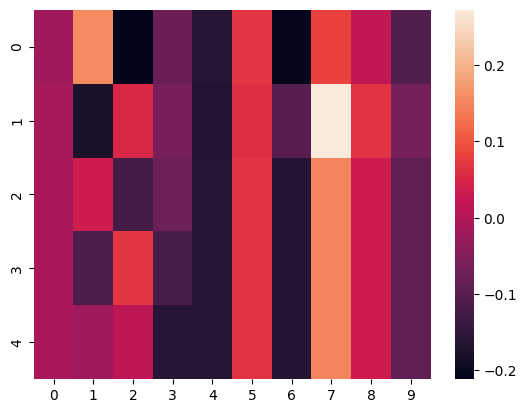

In [22]:
weights = model.state_dict()['0.weight']

sns.heatmap(weights)

# Part C: 2-Layer Linear Model

In [23]:
# TODO: Repeat for 2-layer model

two_layer_model = nn.Sequential(
    nn.Linear(train_X.shape[1], 5),
    nn.Linear(5, 5),
    nn.Softmax(dim=1)
)

optimizer = torch.optim.Adam(two_layer_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train(two_layer_model, optimizer, loss_fn)
test(two_layer_model, loss_fn)

Train Epoch: 1  Loss: 0.9076
Train Epoch: 2  Loss: 0.9053
Train Epoch: 3  Loss: 0.9050
Train Epoch: 4  Loss: 1.0299
Train Epoch: 5  Loss: 0.9049
Train Epoch: 6  Loss: 0.9048
Train Epoch: 7  Loss: 0.9048
Train Epoch: 8  Loss: 0.9048
Train Epoch: 9  Loss: 0.9048
Train Epoch: 10  Loss: 0.9048
Test set: Average loss: 0.0290, Accuracy: 11608/11875 (97.7516)
